<a href="https://colab.research.google.com/github/haris-lutafullah/Research-Work/blob/main/Traffic_Prediction_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Traffic Prediction system using Resnet LSTM

**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

**Data Loading**

In [ ]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')


**Pre-Processing Data**

In [ ]:
df['date_time'] = pd.to_datetime(df['date_time'])
df = df[['date_time', 'traffic_volume']].dropna()

In [ ]:
scaler = MinMaxScaler()
df['traffic_volume'] = scaler.fit_transform(df[['traffic_volume']])

**Creating Time Series Windows**

In [ ]:
#creating Time Series Windoes for 24 i.e. per day
TIME_STEPS = 24
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 1])  # Traffic volume
        y.append(data[i + time_steps, 1])
    return np.array(X), np.array(y)

traffic_data = df.values
X, y = create_time_series(traffic_data, TIME_STEPS)

**Dividing Sample**

In [ ]:
# Split the data
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [ ]:
# Reshape X_train and X_test for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Ensure y_train and y_test are 2D (samples, 1) and are of type float32
y_train = np.array(y_train).reshape(-1, 1).astype(np.float32)
y_test = np.array(y_test).reshape(-1, 1).astype(np.float32)

**Model Creation**

In [ ]:
def resnet_block(input_layer, filters, kernel_size=3):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, input_layer])
    x = Activation('relu')(x)
    return x

**Model Building**

In [ ]:
# Build ResNet-LSTM Model
def build_resnet_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = resnet_block(inputs, filters=64)
    x = resnet_block(x, filters=64)
    x = LSTM(50)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    return model


**Model Compilation**

In [ ]:
# Compile the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_resnet_lstm_model(input_shape)
model.compile(optimizer='adam', loss='mse')


In [ ]:
# Ensure y_train and y_test are 2D (samples, 1) and are of type float32 or float64
y_train = np.array(y_train).reshape(-1, 1).astype(np.float32)
y_test = np.array(y_test).reshape(-1, 1).astype(np.float32)

# Explicitly cast X_train and X_test to float32 as well
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

**Model Fitting / Training**

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 2/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 3/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 4/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 5/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 6/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 7/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 8/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 9/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 10/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 11/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0021 - val_loss: 0.00

**Predicting from the model**

In [ ]:
# Predict traffic on the test set
y_pred = model.predict(X_test)

302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [ ]:
# Rescale the predictions and actual values back to the original scale
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred)

**Evaluations**

In [ ]:
# Calculate performance metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
# Calculate percentage errors
mse_percentage = (mse / np.mean(y_test_rescaled)) * 100
mae_percentage = (mae / np.mean(y_test_rescaled)) * 100

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error Percentage: {mse_percentage:.2f}%")
print(f"Mean Absolute Error Percentage: {mae_percentage:.2f}%")

Mean Squared Error (MSE): 164464.34
Mean Absolute Error (MAE): 256.46
Mean Squared Error Percentage: 5051.39%
Mean Absolute Error Percentage: 7.88%


In [ ]:
# Display actual vs predicted values
predictions_df = pd.DataFrame({
    'Actual Traffic Volume': y_test_rescaled.flatten(),
    'Predicted Traffic Volume': y_pred_rescaled.flatten()
})

print("\nSample Predictions:")
print(predictions_df.head(10))  # Display first 10 predictions


Sample Predictions:
   Actual Traffic Volume  Predicted Traffic Volume
0            1713.000000               1664.909912
1            1068.000000               1556.241333
2             611.000000               1075.083618
3             362.000000                473.911194
4             254.000015                292.667328
5             254.000015                327.641022
6             383.000000                562.283508
7             383.000000                918.313843
8             820.000000               1073.252563
9             820.000000               1963.355347


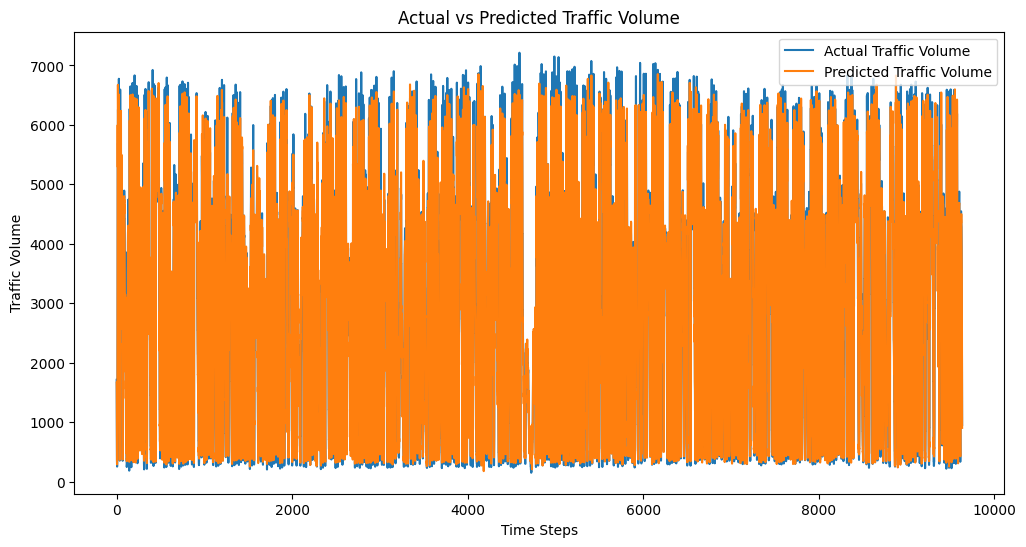

In [ ]:
# Plot actual vs predicted traffic volumes
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Traffic Volume')
plt.plot(y_pred_rescaled, label='Predicted Traffic Volume')
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()